In [2]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector, Attention
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [3]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [4]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [5]:
data = read_text("../input/bilingual-sentence-pairs/deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [6]:
deu_eng = deu_eng[:100000,:]

In [7]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng

array([['Go', 'Geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['Im beginning to get hungry', 'Langsam bekomme ich Hunger',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3737519 (CK) & #5662405 (raggione)'],
       ['Im beginning to get scared', 'Langsam wird mir angst',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3820952 (CK) & #5662416 (raggione)'],
       ['Im beginning to get scared',
        'Langsam bekomme ich es mit der Angst zu tun',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3820952 (CK) & #7969007 (raggione)']],
      dtype='<U537')

In [8]:
# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


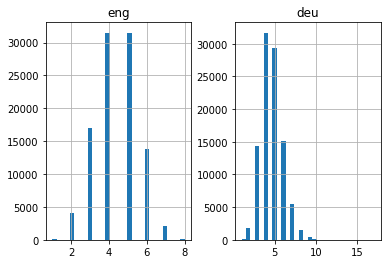

In [9]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

In [10]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [11]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 9228


In [12]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('German Vocabulary Size: %d' % deu_vocab_size)

German Vocabulary Size: 16648


In [13]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [14]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [15]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [16]:
# build NMT model
def define_model1(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    #model.add(Attention())
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    #model.add(Attention())
    model.add(Dense(out_vocab, activation='softmax'))
    return model

def define_model2(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units, dropout=0.5))
    #model.add(Attention())
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, dropout=0.5, return_sequences=True))
    #model.add(Attention())
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [17]:
# model compilation
model1 = define_model1(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
model2 = define_model2(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

In [18]:
rms = optimizers.RMSprop(lr=0.001)
model1.compile(optimizer=rms, loss='sparse_categorical_crossentropy')
model2.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [20]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 8, 512)            8523776   
_________________________________________________________________
lstm (LSTM)                  (None, 512)               2099200   
_________________________________________________________________
repeat_vector (RepeatVector) (None, 8, 512)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8, 512)            2099200   
_________________________________________________________________
dense (Dense)                (None, 8, 9228)           4733964   
Total params: 17,456,140
Trainable params: 17,456,140
Non-trainable params: 0
_________________________________________________________________


In [18]:
filename1 = 'model1.h1'
filename2 = 'model2.h1'
checkpoint1 = ModelCheckpoint(filename1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
checkpoint2 = ModelCheckpoint(filename2, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')

# train model
history1 = model1.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=20, batch_size=512, validation_split = 0.2,callbacks=[checkpoint1, early_stopping], 
                    verbose=1)
history2 = model2.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=20, batch_size=512, validation_split = 0.2,callbacks=[checkpoint2, early_stopping], 
                    verbose=1)

Epoch 1/20
125/125 [==============================] - 347s 3s/step - loss: 4.3604 - val_loss: 3.3056

Epoch 00001: val_loss improved from inf to 3.30564, saving model to model1.h1
Epoch 2/20
125/125 [==============================] - 346s 3s/step - loss: 3.2413 - val_loss: 3.1136

Epoch 00002: val_loss improved from 3.30564 to 3.11356, saving model to model1.h1
Epoch 3/20
125/125 [==============================] - 342s 3s/step - loss: 2.9634 - val_loss: 2.8448

Epoch 00003: val_loss improved from 3.11356 to 2.84484, saving model to model1.h1
Epoch 4/20
125/125 [==============================] - 352s 3s/step - loss: 2.7176 - val_loss: 2.6339

Epoch 00004: val_loss improved from 2.84484 to 2.63392, saving model to model1.h1
Epoch 5/20
125/125 [==============================] - 346s 3s/step - loss: 2.4970 - val_loss: 2.4578

Epoch 00005: val_loss improved from 2.63392 to 2.45785, saving model to model1.h1
Epoch 6/20
125/125 [==============================] - 338s 3s/step - loss: 2.2822 - 

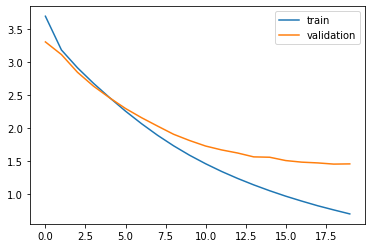

In [19]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

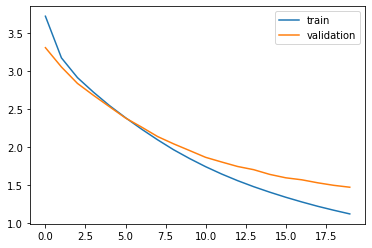

In [20]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [3]:
model1 = load_model('model1.h1')
model2 = load_model('model2.h1')
preds1 = model1.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))
preds2 = model2.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

OSError: SavedModel file does not exist at: model1.h1/{saved_model.pbtxt|saved_model.pb}

In [22]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [23]:
print(preds1.shape)
print(preds2.shape)

(20000, 8)
(20000, 8)


In [24]:
preds_text1 = []
l = len(preds1[0])
for i in preds1:
    temp = []
    for j in range(l):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t) 

    preds_text1.append(' '.join(temp))
    
preds_text2 = []
l = len(preds2[0])
for i in preds2:
    temp = []
    for j in range(l):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t) 

    preds_text2.append(' '.join(temp))

In [25]:
pred_df1 = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text1})
pred_df2 = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text2})